In [1]:
import pandas as pd
import numpy as np
import pickle
import math, scipy
import datetime, sklearn
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from sympy import *
from sklearn import naive_bayes
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
np.warnings.filterwarnings('ignore')

Читаем наши данные и проводим предварительную обработку на основе выводов нулевой лабораторной

In [2]:
A = pd.read_csv('stars.csv', engine='python', sep=',')
Table = A
Table = Table[['Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']]
Table = Table.apply(lambda x : np.log(x) if x.name == 'Radius(R/Ro)' else x)
Table = Table.sort_values('Star type')
Table.head()

,Radius(R/Ro),Absolute magnitude(Mv),Star type
0,-1.771957,16.12,0
188,-2.189256,19.45,0
187,-2.304587,16.67,0
185,-2.329956,16.93,0
184,-2.560061,17.08,0


In [3]:
def Plot(Table, x, y, c = 6, f = lambda x : x):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()

    for a, b in [(i, i) for i in (c if type(c) is list else range(c))]:
        S = Table[(Table['Star type'] <= b) & (Table['Star type'] >= a)]
        ax.scatter(S[x], f(S[y]), label=f"{a}")
        
    plt.legend(loc='upper right')
    plt.show()
    
def PlotAll(Table, x, y, c = 6, f = lambda x : x, function = lambda x, y : x, eps = 0.025):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()

    for a, b in [(i, i) for i in (c if type(c) is list else range(c))]:
        S = Table[(Table['Star type'] <= b) & (Table['Star type'] >= a)]
        ax.scatter(S[x], f(S[y]), label=f"{a}")
        
    xrange = np.arange(Table[x].min(), Table[x].max(), eps)
    yrange = np.arange(f(Table[y]).min(), f(Table[y]).max(), eps)
    X, Y = np.meshgrid(xrange,yrange)

    F = function(X, Y)

    ax.contour(X, Y, F, [0])
    
    plt.legend(loc='upper right')
    plt.show()
    
def Params(slov) -> pd.DataFrame:
    return pd.DataFrame({'parameters' : grid.best_params_.values()}, index=[*grid.best_params_.keys()])

def MetricsEstimates(pipe : Pipeline, Test_data, Test_labels, K = None) -> None:
    y_pred = pipe.predict(Test_data)
    y_true = Test_labels
    
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro')}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro')}")
    
    m = confusion_matrix(y_true, y_pred, labels = [0, 1])
    plt.matshow(m)
    plt.colorbar()
    plt.show()
    
    if K == 1 or K == 2:
        weights = pipe['classifier'].W
        ss = StandardScaler()
        vt = VarianceThreshold()
        t_data = np.c_[vt.fit_transform(ss.fit_transform(Test_data)), Test_labels]
        t_data = pd.DataFrame(t_data, columns = ['Absolute magnitude(Mv)', 'Radius(R/Ro)', 'Star type'])
        PlotAll(t_data, 'Absolute magnitude(Mv)', 'Radius(R/Ro)', 
                function = lambda x, y : weights[0] + weights[1] * x + weights[2] * y)
    elif K == 3:
        weights = np.c_[pipe['classifier'].intercept_, pipe['classifier'].coef_][0]
        ss = StandardScaler()
        vt = VarianceThreshold()
        t_data = np.c_[vt.fit_transform(ss.fit_transform(Test_data)), Test_labels]
        t_data = pd.DataFrame(t_data, columns = ['Absolute magnitude(Mv)', 'Radius(R/Ro)', 'Star type'])
        PlotAll(t_data, 'Absolute magnitude(Mv)', 'Radius(R/Ro)', 
                function = lambda x, y : weights[0] + weights[1] * x + weights[2] * y)

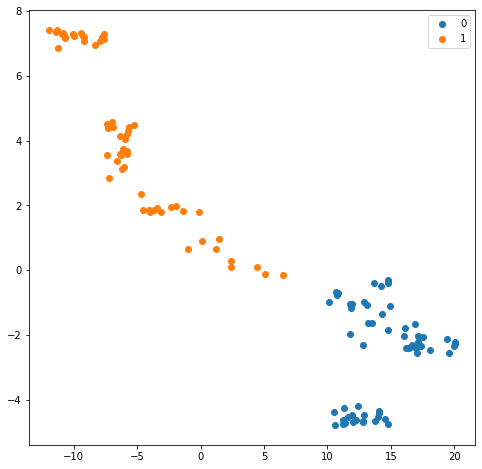

In [4]:
Train = Table.iloc[::2, :]
Test = Table.iloc[1::2, :]

def prepare(Table):
    Res = Table.copy()
    Res['Star type'] = Res['Star type'].apply(lambda x : 0 if x <= 2 else 1)
    return Res

Train = prepare(Train)
Test = prepare(Test)

Plot(Train, 'Absolute magnitude(Mv)', 'Radius(R/Ro)', c = 2)

Разбиваем выборку на тренировочную и обучающую

In [5]:
Train_data = np.array(Train[['Absolute magnitude(Mv)', 'Radius(R/Ro)']])
Train_labels = np.array(Train['Star type'])
Test_data = np.array(Test[['Absolute magnitude(Mv)', 'Radius(R/Ro)']])
Test_labels = np.array(Test['Star type'])

Загрузим гиперпараметры для моделей

In [6]:
try:
    with open('data.pickle', 'rb') as f:
         data = pickle.load(f)
    print(data)
except BaseException as err:
    print(f"{err}")
    data = {}

[Errno 2] No such file or directory: 'data.pickle'


### Логистическая регрессия

In [7]:
class LogitModel(BaseEstimator, ClassifierMixin):
    
    def __sigm(self, x):
        x = np.clip(x, -10, 10)
        return 1.0 / (1.0 + np.exp(-x))
    
    def __init__(self, a = 2, **kwargs):
        self.W = np.random.normal(0, 1, a + 1)
        self.epoch = kwargs.get('epoch', 20)
        self.train_rate = kwargs.get('train_rate', 0.1)
        self.batch = kwargs.get('batch', 4)
        
    def coef(self):
        return self.W
    
    def predict(self, p):
        res = self.predict_proba(p)
        return np.where(res >= 0.5, 1, 0)
    
    def predict_proba(self, p):
        n, m = p.shape
        p = np.c_[np.ones(n), p]
        return self.__sigm(p.dot(self.W))
        
    def fit(self, Train_data, Train_labels):
    
        n, m = Train_data.shape
        Train = np.c_[np.ones(n), Train_data]
    
        for i in range(self.epoch):
            for j in range(0, len(Train), self.batch):
                p = Train[j : j + self.batch]
                y = Train_labels[j : j + self.batch]
                f_p = self.__sigm(p.dot(self.W))
                self.W -= self.train_rate * p.T.dot(f_p - y)
                
        return self
    
    def get_params(self, deep=True):
        return {"epoch": self.epoch, "batch": self.batch, "train_rate": self.train_rate}

#### Собственная реализация

In [8]:
if data == {}:
    parametrs = {
        'epoch' : range(5, 41, 5),
        'batch' : range(2, 32, 4),
        'train_rate' : [0.1, 0.01, 0.001, 0.0001],
    }
    grid = GridSearchCV(LogitModel(), parametrs, cv = 5)
    grid.fit(Train_data, Train_labels)
    Params(grid.best_params_)
    data['LR'] = grid.best_params_
    
    with open('data.pickle', 'wb') as f:
        pickle.dump(data, f)

Accuracy: 1.0
Recall: 1.0
Precision: 1.0


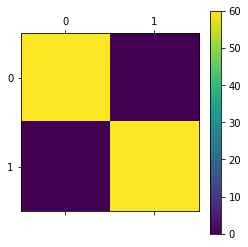

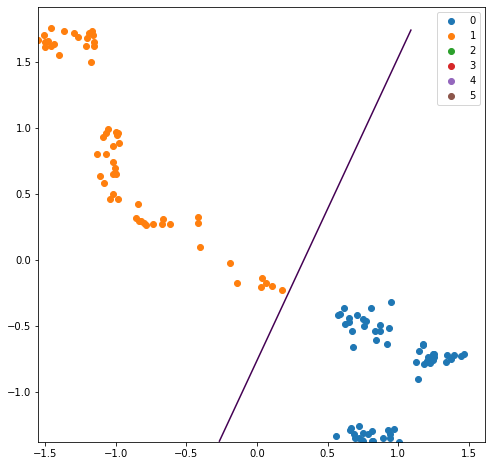

In [9]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', LogitModel(a = 2, **data['LR']))
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels, K = 1)

#### Втроенная реализация

Accuracy: 0.9916666666666667
Recall: 0.9916666666666667
Precision: 0.9918032786885246


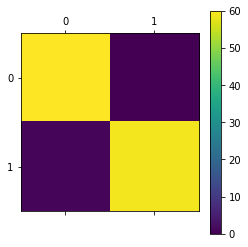

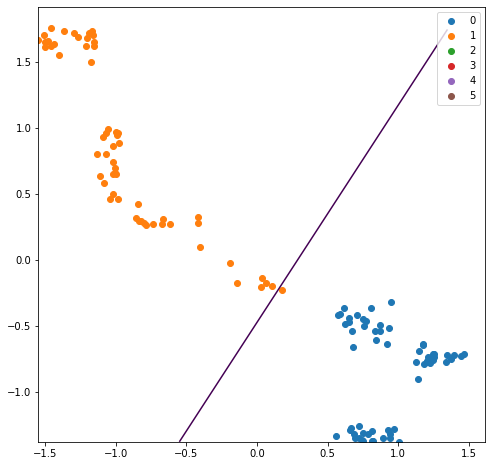

In [10]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', sklearn.linear_model.LogisticRegression())
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels, K = 3)

### Метод опорных векторов

In [11]:
class SVM(BaseEstimator, ClassifierMixin):
    
    def __sigm(self, x):
        x = np.clip(x, -10, 10)
        return 1.0 / (1.0 + np.exp(-x))
    
    def __init__(self, a = 2, **kwargs):
        self.W = np.random.normal(0, 1, a + 1)
        self.alpha = kwargs.get('alpha', 0.1)
        self.epoch = kwargs.get('epoch', 20)
        self.train_rate = kwargs.get('train_rate', 0.1)
        self.batch = kwargs.get('batch', 4)
        
    def coef(self):
        return self.W
    
    def predict(self, p):
        res = self.predict_proba(p)
        return np.where(res >= 0.5, 1, 0)
    
    def predict_proba(self, p):
        n, m = p.shape
        p = np.c_[np.ones(n), p]
        return self.__sigm(p.dot(self.W))
        
    def fit(self, Train_data, Train_labels):
    
        n, m = Train_data.shape
        Train = np.c_[np.ones(n), Train_data]
    
        for i in range(self.epoch):
            for j in range(0, len(Train), self.batch):
                p = Train[j : j + self.batch]
                y = Train_labels[j : j + self.batch] * 2 - 1
                f_p = self.__sigm(p.dot(self.W))
                
                grad = 2 * self.alpha * self.W
                for ib, xb in enumerate(p):
                    if 1 - xb.dot(self.W) * y[ib] > 0:
                        grad -= xb * y[ib]
                
                self.W -= self.train_rate * grad
                
        return self
    
    def get_params(self, deep=True):
        return {"alpha" : self.alpha, "epoch": self.epoch, "batch": self.batch, "train_rate": self.train_rate}

#### Собственная реализация

In [12]:
if 'SVN' not in data.keys():
    parametrs = {
        'alpha' : [0.01, 0.001],
        'epoch' : range(20, 61, 10),
        'batch' : range(2, 9, 2),
        'train_rate' : [0.01, 0.001],
    }
    grid = GridSearchCV(SVM(), parametrs, cv = 5)
    grid.fit(Train_data, Train_labels)
    Params(grid.best_params_)
    
    data['SVN'] = grid.best_params_
    
    with open('data.pickle', 'wb') as f:
        pickle.dump(data, f)

Accuracy: 1.0
Recall: 1.0
Precision: 1.0


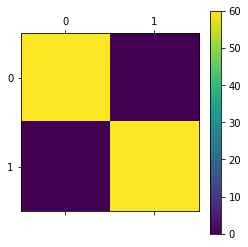

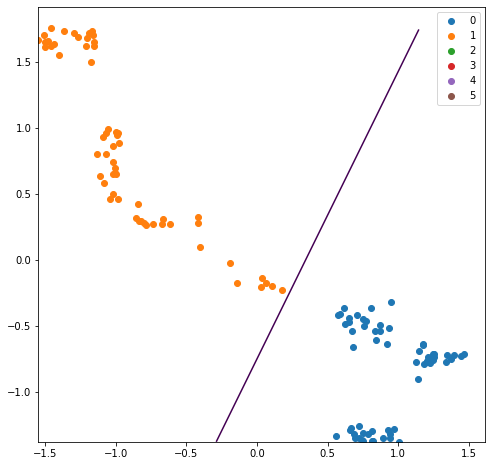

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', SVM(**data['SVN']))
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels, 2)

#### Втроенная реализация

Accuracy: 1.0
Recall: 1.0
Precision: 1.0


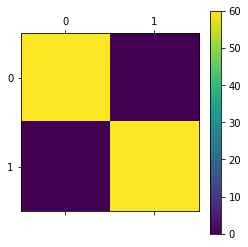

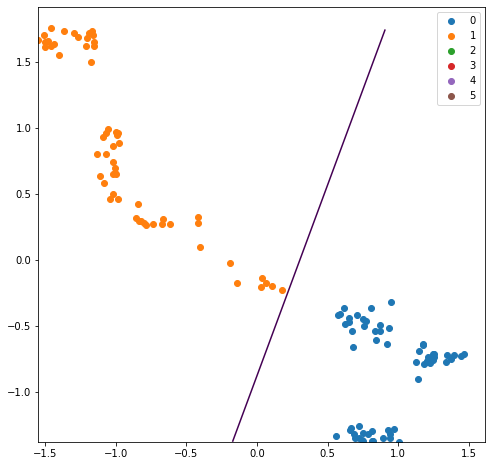

In [14]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', sklearn.svm.SVC(kernel="linear"))
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels, 3)

### Метод k-ближайших соседей

In [15]:
class KNN(BaseEstimator, ClassifierMixin):
    
    def __norm(self, x, y):
        return np.sqrt(np.sum(np.square(x - y)))
    
    def __init__(self, **kwargs):
        self.k = kwargs.get('k', 5)
        self.data = None
        
    def predict(self, p):
        result = []
        for x in p:
            self.data.sort(key = lambda t : self.__norm(t[0], x))
            result.append(np.bincount(np.array([i[1] for i in self.data[:self.k]])).argmax())
        return np.array(result)
    
    def fit(self, Train_data, Train_labels):
    
        self.data = [(Train_data[i], Train_labels[i]) for i in range(len(Train_data))]
        return self
    
    def get_params(self, deep=True):
        return {"k": self.k}

#### Собственная реализация

In [16]:
if 'KNN' not in data.keys():
    parametrs = {
        'k' : range(3, 12, 2),
    }
    grid = GridSearchCV(KNN(), parametrs, cv = 5)
    grid.fit(Train_data, Train_labels)
    Params(grid.best_params_)
    
    data['KNN'] = grid.best_params_
    
    with open('data.pickle', 'wb') as f:
        pickle.dump(data, f)

Accuracy: 1.0
Recall: 1.0
Precision: 1.0


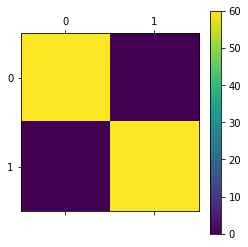

In [17]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', KNN(**data['KNN']))
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels)

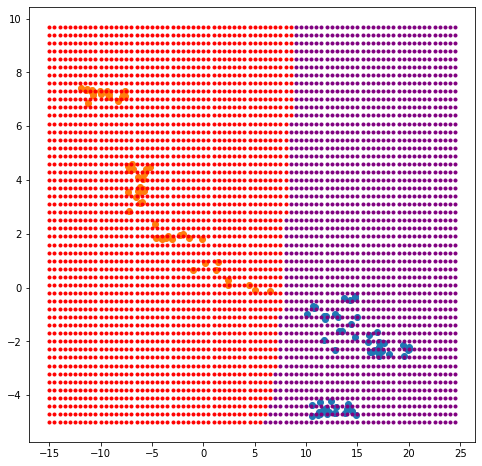

In [18]:
nbc = KNN().fit(Train_data, Train_labels)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

for a, b in [(i, i) for i in range(2)]:
    S = Train[(Train['Star type'] <= b) & (Train['Star type'] >= a)]

    ax.scatter(S['Absolute magnitude(Mv)'], S['Radius(R/Ro)'], label=f"{a}")
    
for x in np.arange(-15, 25, 0.5):
    for y in np.arange(-5, 10, 0.3):
        a = nbc.predict(np.array([[x, y]]))
        ax.plot([x], [y], '.', color = 'purple' if a == 0 else 'red')
        
plt.show()

#### Встроенная реализация

Accuracy: 1.0
Recall: 1.0
Precision: 1.0


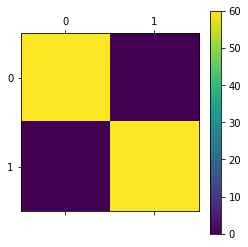

In [19]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', sklearn.neighbors.KNeighborsClassifier())
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels)

### Наивный байесовский классификатор

In [20]:
class NBC(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        self.P = {}
        self.M = {}
        self.D = {}
        
    def predict(self, p):
        result = []
        for x in p:
            maxp, maxclass = None, None
            for y in self.P.keys():
                if (maxp == maxclass == None) or self.predict_proba(x, y) > maxp:
                    maxp = self.predict_proba(x, y)
                    maxclass = y
                    
            result.append(maxclass)
        return np.array(result)
    
    def predict_proba(self, x, y):
        result = 1
        
        for i in range(len(x)):
            result *= 1.0 / (np.sqrt(2*np.pi) * self.D[y][i]) * np.exp(- (x[i] - self.M[y][i])**2 / (2 * self.D[y][i]**2))
        
        return self.P[y] * result
    
    def fit(self, Train_data, Train_labels):
        self.P = {i : sum(Train_labels == i) / len(Train_labels) for i in set(Train_labels)}

        for i in self.P.keys():
            acc = np.zeros_like(Train_data[0])
            for j in range(len(Train_data)):
                if Train_labels[j] == i:
                    acc += Train_data[j]
            acc /= sum(Train_labels == i)
            self.M[i] = acc
        
        for i in self.P.keys():
            acc = np.zeros_like(Train_data[0])
            for j in range(len(Train_data)):
                if Train_labels[j] == i:
                    acc += np.square(Train_data[j] - self.M[i])
            acc /= sum(Train_labels == i) - 1
            self.D[i] = acc
        
        return self
    
    def get_params(self, deep=True):
        return {"P": self.P, "M": self.M}

#### Собственная реализация

Accuracy: 1.0
Recall: 1.0
Precision: 1.0


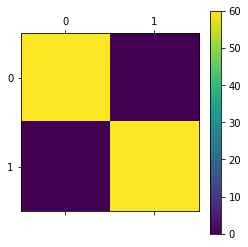

In [21]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', NBC())
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels)

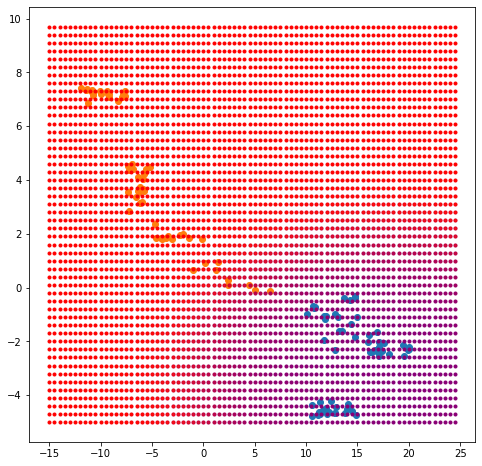

In [22]:
nbc = NBC().fit(Train_data, Train_labels)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

for a, b in [(i, i) for i in range(2)]:
    S = Train[(Train['Star type'] <= b) & (Train['Star type'] >= a)]

    ax.scatter(S['Absolute magnitude(Mv)'], S['Radius(R/Ro)'], label=f"{a}")
    
for x in np.arange(-15, 25, 0.5):
    for y in np.arange(-5, 10, 0.3):
        a = nbc.predict_proba(np.array([x, y]), y = 0)
        b = nbc.predict_proba(np.array([x, y]), y = 1)
        ab = np.array([a, b])
        ab = ab / np.linalg.norm(ab)
        ax.plot([x], [y], '.', color = 'purple', alpha = ab[0])
        ax.plot([x], [y], '.', color = 'red', alpha = ab[1])
        
plt.show()

#### Встроенная реализация

Accuracy: 0.9916666666666667
Recall: 0.9916666666666667
Precision: 0.9918032786885246


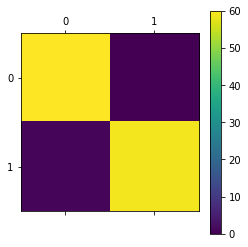

In [23]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', sklearn.naive_bayes.GaussianNB())
]).fit(Train_data, Train_labels)

MetricsEstimates(pipe, Test_data, Test_labels)